In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import json
from pathlib import Path
import torch
from torch.utils.data import DataLoader
import time

2. Mengambil Dataset

In [ ]:
#Memasukkan path data train
path = Path('/content/drive/MyDrive/Colab Notebooks/BERT/Dataset Terjemah Arbain An-Nawawi (v.3)/[8] Train_Panjang_v.3.json')

#Membuka file .json
with open(path, 'rb') as f:
    squad_dict = json.load(f)

texts = []
queries = []
answers = []

#Pencocokan konteks, pertanyaan, dan jawaban
for group in squad_dict['data']:
    for passage in group['paragraphs']:
        context = passage['context']
        for qa in passage['qas']:
            question = qa['question']
            for answer in qa['answers']:
#Menyimpan konteks, pertanyaan, dan jawaban ke dalam list
                texts.append(context)
                queries.append(question)
                answers.append(answer)

train_texts, train_queries, train_answers = texts, queries, answers

In [ ]:
#Memasukkan path data validation
path = Path('/content/drive/MyDrive/Colab Notebooks/BERT/Dataset Terjemah Arbain An-Nawawi (v.3)/[8] Val_Panjang_v.3.json')

#Membuka file .json
with open(path, 'rb') as f:
    squad_dict = json.load(f)

texts = []
queries = []
answers = []

#Pencocokan konteks, pertanyaan, dan jawaban
for group in squad_dict['data']:
    for passage in group['paragraphs']:
        context = passage['context']
        for qa in passage['qas']:
            question = qa['question']
            for answer in qa['answers']:
#Menyimpan konteks, pertanyaan, dan jawaban ke dalam list
                texts.append(context)
                queries.append(question)
                answers.append(answer)

val_texts, val_queries, val_answers = texts, queries, answers

3. Cek Data

In [ ]:
#Jumlah Data Train
print(len(train_texts))
print(len(train_queries))
print(len(train_answers))

112
112
112


In [ ]:
a = 1

print("Konteks: ",train_texts[a])
print("Pertanyaan: ",train_queries[a])
print("Jawaban: ",train_answers[a])

#ket:
#1. huruf besar dan kecil mempengaruhi nilai answer_start
#2. jawaban harus mengutip isi dari konteks
#3. tidak boleh menghilangkan imbuhan
#4. tidak boleh menambahkan satu kata ataupun simbol
#5. tidak boleh menggunakan tanda kutip dua (" ")
#6. kelebihan atau kekurangan spasi akan mempengaruhi nilai answer_start

Konteks:  dari umar radhiyallahu 'anhu juga berkata, 'ketika kami duduk-duduk di sisi rasulullah shallallahu 'alaihi wa sallam suatu hari tiba-tiba datanglah seorang laki-laki yang mengenakan baju yang sangat putih dan berambut sangat hitam, tidak tampak padanya bekas-bekas perjalanan jauh dan tidak ada seorangpun di antara kami yang mengenalnya. hingga kemudian dia duduk di hadapan nabi lalu menempelkan kedua lututnya kepada lutut beliau seraya berkata, 'wahai muhammad, beritahukan kepadaku tentang islam?' rasulullah shallallahu 'alaihi wa sallam menjawab, 'islam adalah engkau bersaksi bahwa tidak ada ilah yang berhak diibadahi selain allah, dan bahwa muhammad adalah utusan allah, engkau mendirikan shalat, menunaikan zakat, berpuasa di bulan ramadhan, dan pergi haji jika mampu'. kemudian orang itu berkata, 'engkau benar'. kami semua merasa heran kepadanya, dia yang menanyakan tetapi dia pula yang membenarkannya. kemudian dia bertanya lagi, 'beritahukan kepadaku tentang iman?' rasulull

In [ ]:
#Jumlah Data Validation
print(len(val_texts))
print(len(val_queries))
print(len(val_answers))

48
48
48


In [ ]:
b = 2

print("Konteks: ",val_texts[b])
print("Pertanyaan: ",val_queries[b])
print("Jawaban: ",val_answers[b])

Konteks:  dari umar radhiyallahu 'anhu juga berkata, 'ketika kami duduk-duduk di sisi rasulullah shallallahu 'alaihi wa sallam suatu hari tiba-tiba datanglah seorang laki-laki yang mengenakan baju yang sangat putih dan berambut sangat hitam, tidak tampak padanya bekas-bekas perjalanan jauh dan tidak ada seorangpun di antara kami yang mengenalnya. hingga kemudian dia duduk di hadapan nabi lalu menempelkan kedua lututnya kepada lutut beliau seraya berkata, 'wahai muhammad, beritahukan kepadaku tentang islam?' rasulullah shallallahu 'alaihi wa sallam menjawab, 'islam adalah engkau bersaksi bahwa tidak ada ilah yang berhak diibadahi selain allah, dan bahwa muhammad adalah utusan allah, engkau mendirikan shalat, menunaikan zakat, berpuasa di bulan ramadhan, dan pergi haji jika mampu'. kemudian orang itu berkata, 'engkau benar'. kami semua merasa heran kepadanya, dia yang menanyakan tetapi dia pula yang membenarkannya. kemudian dia bertanya lagi, 'beritahukan kepadaku tentang iman?' rasulull

4. Penentuan end index

In [ ]:
for answer, text in zip(train_answers, train_texts):
    real_answer = answer['text']
    start_idx = answer['answer_start']
    #Nilai end index sebenarnya
    end_idx = start_idx + len(real_answer)

    #Ketika real answer sesuai
    if text[start_idx:end_idx] == real_answer:
        answer['answer_end'] = end_idx
    #Ketika real answer lebih dari 1 karakter
    elif text[start_idx-1:end_idx-1] == real_answer:
        answer['answer_start'] = start_idx - 1
        answer['answer_end'] = end_idx - 1
    #Ketika real answer lebih dari 2 karakter
    elif text[start_idx-2:end_idx-2] == real_answer:
        answer['answer_start'] = start_idx - 2
        answer['answer_end'] = end_idx - 2

In [ ]:
for answer, text in zip(val_answers, val_texts):
    real_answer = answer['text']
    start_idx = answer['answer_start']
    #Nilai end index sebenarnya
    end_idx = start_idx + len(real_answer)

    #Ketika real answer sesuai
    if text[start_idx:end_idx] == real_answer:
        answer['answer_end'] = end_idx
    #Ketika real answer lebih dari 1 karakter
    elif text[start_idx-1:end_idx-1] == real_answer:
        answer['answer_start'] = start_idx - 1
        answer['answer_end'] = end_idx - 1
    #Ketika real answer lebih dari 2 karakter
    elif text[start_idx-2:end_idx-2] == real_answer:
        answer['answer_start'] = start_idx - 2
        answer['answer_end'] = end_idx - 2

5. Tokenisasi Passages dan Queries

In [ ]:
from transformers import AutoTokenizer,AdamW,BertForQuestionAnswering
tokenizer = AutoTokenizer.from_pretrained("Rifky/Indobert-QA")

train_encodings = tokenizer(train_texts, train_queries, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, val_queries, truncation=True, padding=True)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


6. Convert The Start-End Positions to Tokens Start-End Positions

In [ ]:
def add_token_positions(encodings, answers):
  start_positions = []
  end_positions = []

  count = 0

  for i in range(len(answers)):
    start_positions.append(encodings.char_to_token(i, answers[i]['answer_start']))
    end_positions.append(encodings.char_to_token(i, answers[i]['answer_end']))

    # if start position is None, the answer passage has been truncated
    if start_positions[-1] is None:
      start_positions[-1] = tokenizer.model_max_length

    # if end position is None, the 'char_to_token' function points to the space after the correct token, so add - 1
    if end_positions[-1] is None:
      end_positions[-1] = encodings.char_to_token(i, answers[i]['answer_end'] - 1)
      # if end position is still None the answer passage has been truncated
      if end_positions[-1] is None:
        count += 1
        end_positions[-1] = tokenizer.model_max_length

  print(count)

  #Update data
  encodings.update({'start_positions': start_positions, 'end_positions': end_positions})

add_token_positions(train_encodings, train_answers)
add_token_positions(val_encodings, val_answers)

0
0


7. Membuat Kelas Dataset

In [ ]:
class SquadDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

In [ ]:
train_dataset = SquadDataset(train_encodings)
val_dataset = SquadDataset(val_encodings)

In [ ]:
#Menggunakan Dataloader
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

In [ ]:
#Menggunakan GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Working on:', device)

Working on: cpu


8. Membangun Model

In [ ]:
model = BertForQuestionAnswering.from_pretrained("Rifky/Indobert-QA").to(device)

#optim = AdamW(model.parameters(), lr=5e-5)
#optim = AdamW(model.parameters(), lr=4e-5)
#optim = AdamW(model.parameters(), lr=3e-5)
#optim = AdamW(model.parameters(), lr=2e-5)
optim = AdamW(model.parameters(), lr=1e-5)

epochs = 5

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


9. Train and Evaluate Model

In [ ]:
whole_train_eval_time = time.time()

train_losses = []
val_losses = []

print_every = 10

for epoch in range(epochs):
  epoch_time = time.time()

  #train mode
  model.train()

  loss_of_epoch = 0

  print("############Train############")

  for batch_idx,batch in enumerate(train_loader):

    optim.zero_grad()

    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    start_positions = batch['start_positions'].to(device)
    end_positions = batch['end_positions'].to(device)

    outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
    loss = outputs[0]
    #backwards pass
    loss.backward()
    #update bobot
    optim.step()
    #Hitung nilai loss
    loss_of_epoch += loss.item()

    if (batch_idx+1) % print_every == 0:
      print("Batch {:} / {:}".format(batch_idx+1,len(train_loader)),"\nLoss:", round(loss.item(),1),"\n")

  loss_of_epoch /= len(train_loader)
  train_losses.append(loss_of_epoch)

  ##########Evaluation##################

  #evaluation mode
  model.eval()

  print("############Evaluate############")

  loss_of_epoch = 0

  for batch_idx,batch in enumerate(val_loader):

    with torch.no_grad():

      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      start_positions = batch['start_positions'].to(device)
      end_positions = batch['end_positions'].to(device)

      outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
      loss = outputs[0]
      #Hitung nilai loss
      loss_of_epoch += loss.item()

    if (batch_idx+1) % print_every == 0:
       print("Batch {:} / {:}".format(batch_idx+1,len(val_loader)),"\nLoss:", round(loss.item(),1),"\n")

  loss_of_epoch /= len(val_loader)
  val_losses.append(loss_of_epoch)

  #Print hasil tiap epoch
  print("\n-------Epoch ", epoch+1,
        "-------"
        "\nTraining Loss:", train_losses[-1],
        "\nValidation Loss:", val_losses[-1],
        "\nTime: ",(time.time() - epoch_time),
        "\n-----------------------",
        "\n\n")

print("Total training and evaluation time: ", (time.time() - whole_train_eval_time))

############Train############
Batch 10 / 14 
Loss: 3.2 

############Evaluate############

-------Epoch  1 -------
Training Loss: 3.8602664981569563 
Validation Loss: 2.678164084752401 
Time:  665.9868519306183 
----------------------- 


############Train############
Batch 10 / 14 
Loss: 1.5 

############Evaluate############

-------Epoch  2 -------
Training Loss: 1.9721223286220007 
Validation Loss: 2.112583875656128 
Time:  653.9515347480774 
----------------------- 


############Train############
Batch 10 / 14 
Loss: 0.7 

############Evaluate############

-------Epoch  3 -------
Training Loss: 1.229507246187755 
Validation Loss: 1.8857176701227825 
Time:  666.8462088108063 
----------------------- 


############Train############
Batch 10 / 14 
Loss: 0.6 

############Evaluate############

-------Epoch  4 -------
Training Loss: 0.8368600308895111 
Validation Loss: 2.1300892432530723 
Time:  666.2719483375549 
----------------------- 


############Train############
Batch 10 / 14

In [ ]:
#Save model

torch.save(model,"/content/drive/MyDrive/Colab Notebooks/BERT/Model_Terjemahan_Arbain_v.3/Panjang_v.3_e(5),l(0,00001),b(8)")

10. Plot Train & Val Loss

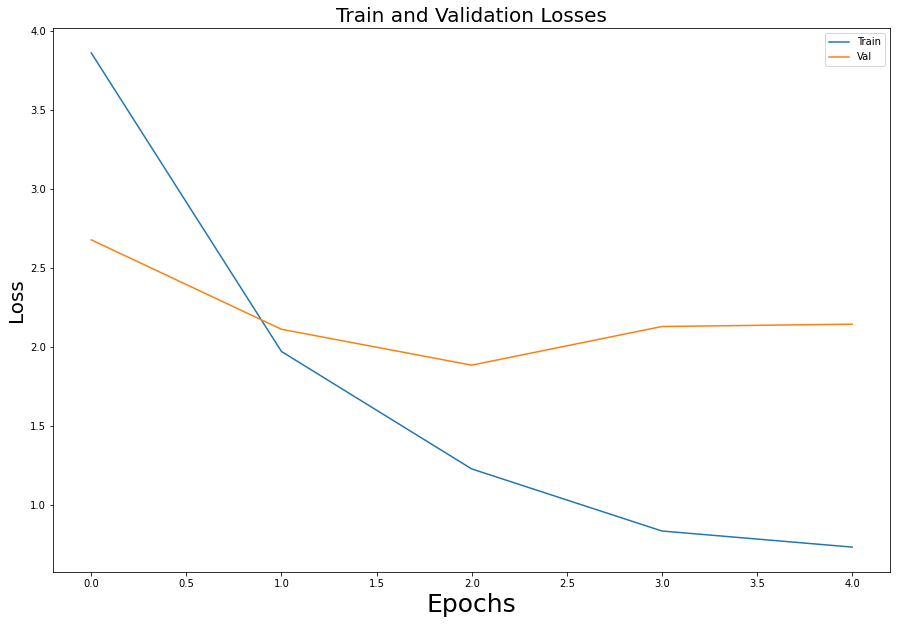

In [ ]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,1,figsize=(15,10))

ax.set_title("Train and Validation Losses",size=20)
ax.set_ylabel('Loss', fontsize = 20)
ax.set_xlabel('Epochs', fontsize = 25)
_=ax.plot(train_losses)
_=ax.plot(val_losses)
_=ax.legend(('Train','Val'),loc='upper right')